In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import jdatetime
from sklearn.cluster import KMeans

In [6]:
file_path = "C:\\Users\\sepeh\\Downloads\\Stores_Transactions.csv"
data = pd.read_csv(file_path)

In [7]:
data.describe()

user_id  transaction_id     quantity    unit_price   total_price  \
count  8192.000000     8192.000000  8192.000000  8.192000e+03  8.192000e+03   
mean      6.557617      161.153320     2.965576  2.170055e+06  3.426030e+06   
std       3.468765       93.056739     3.949849  6.191959e+06  9.584929e+06   
min       1.000000        1.000000     1.000000  5.013100e+03  5.035480e+03   
25%       4.000000       81.000000     1.000000  8.416818e+04  1.853002e+05   
50%       7.000000      161.000000     2.000000  2.872106e+05  5.467666e+05   
75%      10.000000      242.000000     3.000000  9.350427e+05  1.939030e+06   
max      12.000000      348.000000    48.000000  4.999451e+07  1.406411e+08   

       total_amount  total_items  
count  8.192000e+03  8192.000000  
mean   6.339663e+06     8.775513  
std    1.393022e+07     9.698697  
min    7.839930e+03     1.000000  
25%    8.157042e+05     3.000000  
50%    1.944458e+06     5.000000  
75%    4.701880e+06    10.000000  
max    1.406411e+08    50.000000

In [8]:
len(np.unique(data["transaction_date"]))

215

In [9]:
len(data["transaction_date"])

8192

In [10]:
data["transaction_date_gregorian"] = data["transaction_date"].apply(
    lambda x: jdatetime.datetime.strptime(x, '%Y-%m-%d').togregorian()
)
data["transaction_date"] = pd.to_datetime(data["transaction_date_gregorian"])

In [11]:
data['7_day_period'] = ((data["transaction_date"].dt.day - 1) // 7) + 1
data['week_label'] = data["transaction_date"].dt.strftime('%Y-%m-%d') + " (Week " + data['7_day_period'].astype(str) + ")"

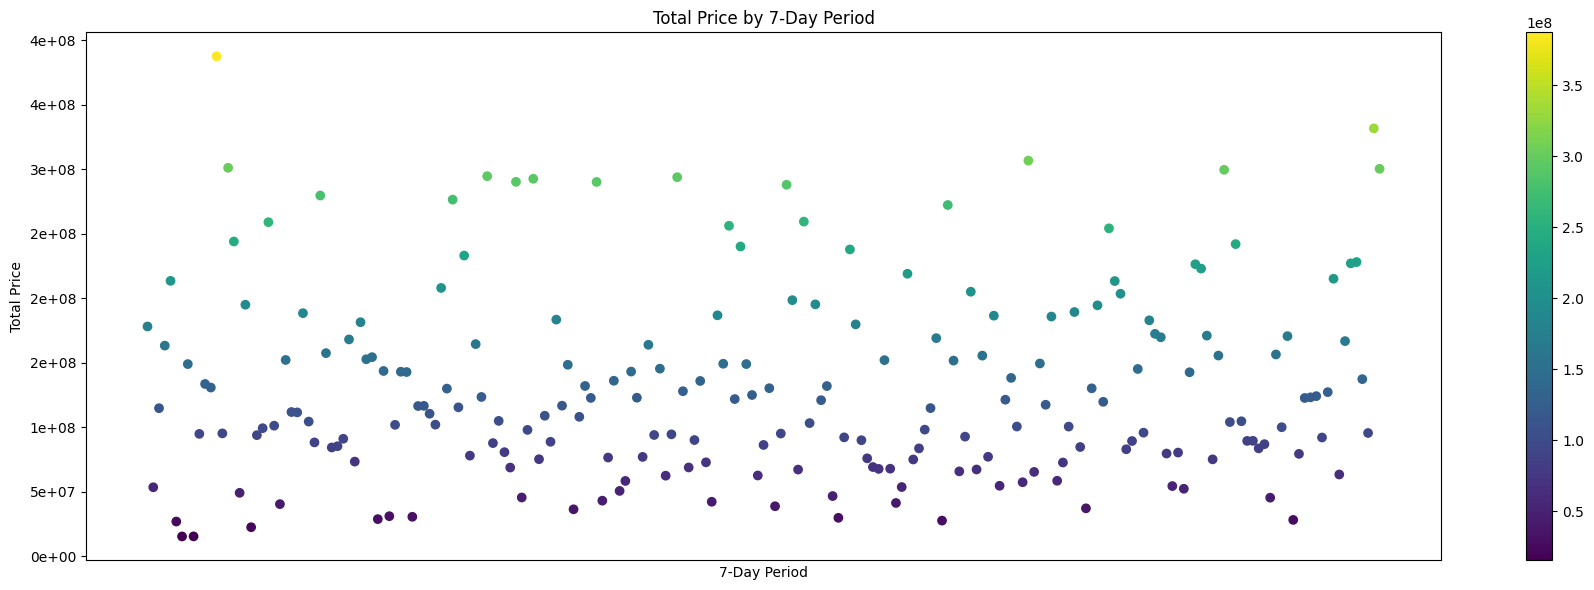

In [12]:
data_grouped = data.groupby('week_label')['total_price'].sum().reset_index()
plt.figure(figsize=(18, 6))
plt.scatter(data_grouped["week_label"], data_grouped["total_price"], c=data_grouped["total_price"], cmap="viridis")
plt.xlabel("7-Day Period")
plt.ylabel("Total Price")
plt.title("Total Price by 7-Day Period")
plt.xticks(rotation=85, ha="right")
formatter = FuncFormatter(lambda x, pos: '{:.0e}'.format(x))
plt.gca().yaxis.set_major_formatter(formatter)
plt.colorbar()
plt.xticks([])
plt.tight_layout()
plt.show()

In [13]:
data['day_of_week'] = data["transaction_date"].dt.dayofweek
sales_by_day = data.groupby('day_of_week')['total_price'].sum().reset_index()
top_3_days = sales_by_day.sort_values('total_price', ascending=False).head(3)
day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
top_3_days['day_name'] = top_3_days['day_of_week'].map(day_names)
print(top_3_days[['day_name', 'total_price']])

    day_name   total_price
5   Saturday  4.526381e+09
2  Wednesday  4.405634e+09
1    Tuesday  4.194348e+09


In [14]:
store_sales = data.groupby("store")["total_price"].sum()
best_store = store_sales.idxmax()
best_sales = store_sales.max()
print(f"The store with the highest sales is {best_store} with total sales of {best_sales}")

The store with the highest sales is Jewelry Store with total sales of 12260376116.87


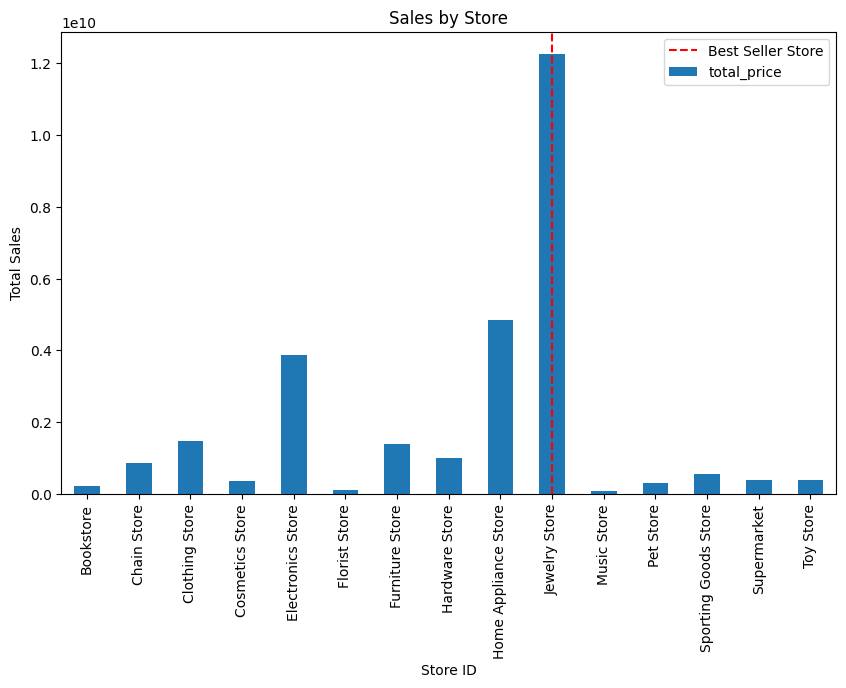

In [15]:
plt.figure(figsize=(10, 6))
store_sales.plot(kind='bar')
plt.xlabel("Store ID")
plt.ylabel("Total Sales")
plt.title("Sales by Store")
plt.axvline(x=store_sales.index.get_loc(best_store), color='r', linestyle='--', label='Best Seller Store')
plt.legend()
plt.show()

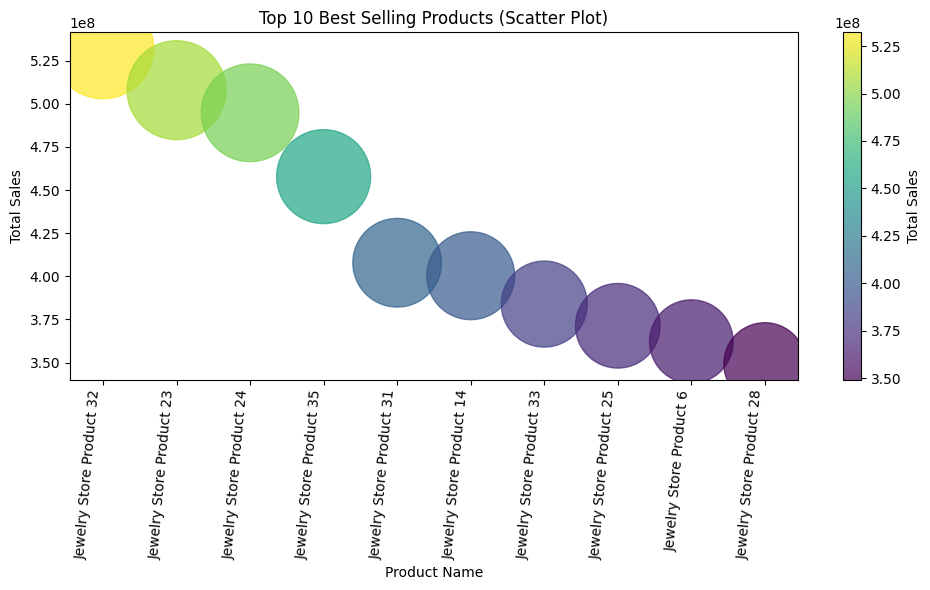

In [16]:
product_sales = data.groupby("product_name")["total_price"].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
plt.scatter(product_sales.index, product_sales.values, s=product_sales.values/100000, c=product_sales.values, cmap="viridis", alpha=0.7)
plt.xlabel("Product Name")
plt.ylabel("Total Sales")
plt.title("Top 10 Best Selling Products (Scatter Plot)")
plt.colorbar(label='Total Sales')
plt.xticks(rotation=85, ha="right")
plt.tight_layout()
plt.show()

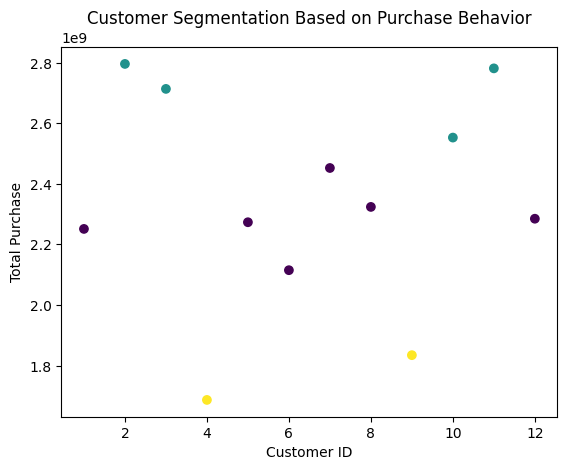

In [22]:
customer_data = data.groupby("user_id")["total_price"].sum().reset_index()
kmeans = KMeans(n_clusters=3)
customer_data["cluster"] = kmeans.fit_predict(customer_data[["total_price"]])
plt.scatter(customer_data["user_id"], customer_data["total_price"], c=customer_data["cluster"], cmap='viridis')
plt.xlabel("Customer ID")
plt.ylabel("Total Purchase")
plt.title("Customer Segmentation Based on Purchase Behavior")
plt.show()

In [46]:
# محاسبه میانگین و انحراف معیار قیمت کل یک تراکنش
mean_total_price_single = data['total_price'].mean()
std_total_price_single = data['total_price'].std()

print(f"میانگین قیمت کل یک خرید: {mean_total_price_single}")
print(f"انحراف معیار قیمت کل یک خرید: {std_total_price_single}")

# محاسبه آستانه اعتبار (میانگین + 2 * انحراف معیار) * تعداد خرید
data['num_purchases'] = data.groupby('user_id')['transaction_id'].transform('count')  # تعداد خریدهای هر کاربر
threshold_credit = (2*mean_total_price_single +  10* std_total_price_single) * data['num_purchases']

print(f"آستانه اعتبار (میانگین + 3 * انحراف معیار) * تعداد خرید: {threshold_credit}")

# انتخاب کاربرانی که مجموع خریدهایشان بیشتر از آستانه اعتبار باشد
eligible_for_credit = data[data['total_price'] * data['num_purchases'] > threshold_credit]

# نمایش کاربران یگانه واجد شرایط
unique_eligible_users = eligible_for_credit[['user_id', 'total_price', 'num_purchases']].drop_duplicates(subset='user_id')

print(f"کاربران یگانه که واجد شرایط اعتبار هستند:\n{unique_eligible_users}")


میانگین قیمت کل یک خرید: 3426029.835074463
انحراف معیار قیمت کل یک خرید: 9584928.924576962
آستانه اعتبار (میانگین + 3 * انحراف معیار) * تعداد خرید: 0       6.788559e+10
1       6.788559e+10
2       6.788559e+10
3       6.788559e+10
4       6.788559e+10
            ...     
8187    6.768019e+10
8188    6.768019e+10
8189    6.768019e+10
8190    6.768019e+10
8191    6.768019e+10
Name: num_purchases, Length: 8192, dtype: float64
کاربران یگانه که واجد شرایط اعتبار هستند:
      user_id   total_price  num_purchases
323         1  1.312020e+08            661
1222        2  1.285852e+08            673
1542        3  1.045217e+08            708
3131        5  1.120149e+08            624
5668        9  1.083491e+08            689
6154       10  1.406411e+08            725
7229       11  1.180052e+08            762
7811       12  1.034912e+08            659


In [ ]:
user_data = data[data["user_id"] == 12]
total_quantity = user_data["quantity"].sum()
print(f"مجموع مقادیر quantity برای کاربر 12: {total_quantity}")

______________________________________________________<>__________________________________________________